Обработка данныx:

In [443]:
import pandas as pd
from tqdm.notebook import tqdm
import re
import copy

In [444]:
df = pd.read_csv('train.csv')
df.head(10)

,comment_text,is_toxic,toxic_level,insult,obscene,obscene_and_insult,no_obscene_no_insult
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,4,0,0,1,0
7,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,alignment on this subject and which are contra...,0,0,0,0,0,0


In [445]:
print(len(df['comment_text']))
print(len(df['is_toxic']))

159571
159571


In [446]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def preprocessing(example_string):
    lemmatizer = WordNetLemmatizer() 
    stop_words = set(stopwords.words('english'))
    x = re.sub('[^A-Za-z0-9]', ' ', example_string)
    x_list = x.split()
    answ = [lemmatizer.lemmatize(word) for word in x_list]
    
    filtered_sentence = []
    for w in answ:  
        if w not in stop_words:  
            filtered_sentence.append(w)
            
    if filtered_sentence :
      return(' '.join(filtered_sentence))

In [447]:
data = df['comment_text'].str.lower().apply(preprocessing)
print(len(data))

159571


In [448]:
target = copy.deepcopy(df['is_toxic'])
target[target == 0]=-1
target = target.to_numpy()
print(len(target))

159571


In [449]:
indexes = data.notna()
data = data[indexes]
target = target[indexes]

In [450]:
from sklearn.model_selection import train_test_split
X_train_, X_test_, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=42)

In [451]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df = 5)
vectorizer.fit(X_train_)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=5, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [452]:
X_train = vectorizer.transform(X_train_)
X_test = vectorizer.transform(X_test_)

In [453]:
from scipy.sparse import hstack, csr_matrix
import numpy as np
X_train = csr_matrix(hstack([csr_matrix(np.ones((X_train.shape[0], 1))), X_train]))
X_test = csr_matrix(hstack([csr_matrix(np.ones((X_test.shape[0], 1))), X_test]))

In [454]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(111685, 26050)
(47865, 26050)
(111685,)
(47865,)


Числинные эксперименты:

# 4):

In [532]:
#ограничим данные для быстрого обучения
#X_train = X_train[:20000]
#y_train = y_train[:20000]

In [456]:
alpha = np.arange(1, 3, 0.5)
betha = np.arange(0, 3, 0.5)
print(alpha)
print(betha)

[1.  1.5 2.  2.5]
[0.  0.5 1.  1.5 2.  2.5]


In [379]:
answ = {}
for i in range(len(alpha)):
    answ[alpha[i]] = []
    for j in range(len(betha)):
        example = {betha[j]:[]}
        answ[alpha[i]].append(example)
print(answ)
print(((answ[alpha[0]][2]))[betha[2]])

{1.0: [{0.0: []}, {0.5: []}, {1.0: []}, {1.5: []}, {2.0: []}, {2.5: []}], 1.5: [{0.0: []}, {0.5: []}, {1.0: []}, {1.5: []}, {2.0: []}, {2.5: []}], 2.0: [{0.0: []}, {0.5: []}, {1.0: []}, {1.5: []}, {2.0: []}, {2.5: []}], 2.5: [{0.0: []}, {0.5: []}, {1.0: []}, {1.5: []}, {2.0: []}, {2.5: []}]}
[]


In [380]:
from modules.losses import BinaryLogisticLoss
from modules.linear_model import LinearModel
from sklearn.metrics import balanced_accuracy_score

for i in range(len(alpha)):
    for j in range(len(betha)):
        loss_function = BinaryLogisticLoss(l2_coef=0.1)
        linear_model = LinearModel(
        loss_function=loss_function,
        step_alpha=alpha[i],
        step_beta=betha[j],
        tolerance=1e-5,
        max_iter=100,
        )
        history = linear_model.fit(X_train, y_train, trace=True, X_val=X_test, y_val=y_test)
        predictions = linear_model.predict(X_test)
        score = balanced_accuracy_score(y_test, predictions)
        (((answ[alpha[i]][j]))[betha[j]]).append(history)
        (((answ[alpha[i]][j]))[betha[j]]).append(score)
        print(alpha[i]," ", betha[j], " done")

1.0   0.0  done
1.0   0.5  done
1.0   1.0  done
1.0   1.5  done
1.0   2.0  done
1.0   2.5  done
1.5   0.0  done
1.5   0.5  done
1.5   1.0  done
1.5   1.5  done
1.5   2.0  done
1.5   2.5  done
2.0   0.0  done
2.0   0.5  done
2.0   1.0  done
2.0   1.5  done
2.0   2.0  done
2.0   2.5  done
2.5   0.0  done
2.5   0.5  done
2.5   1.0  done
2.5   1.5  done
2.5   2.0  done
2.5   2.5  done


In [374]:
def getItime(arr):
    answ = np.zeros(len(arr))
    answ[0] = arr[0] 
    for i in range(1, len(arr)):
        answ[i] = arr[i] + answ[i-1]
    return answ

Исследуем графики:

In [381]:
score_ = []
for i in range(len(alpha)):
    score_ .append([])
    for j in range(len(betha)):
        score_[i].append(((answ[alpha[i]][j]))[betha[j]][1])


In [382]:
print((score_))

[[0.46300570736570446, 0.6211884208451939, 0.6978987821002067, 0.592872666831454, 0.5902973953557672, 0.5903678204326288], [0.44655550459588067, 0.5536910301923086, 0.5861846644231464, 0.4588355672279274, 0.5905049934458648, 0.5903569409192656], [0.44671737834823294, 0.6249694399485006, 0.5850352168304374, 0.4533406847851202, 0.5837611226145462, 0.5904034006851084], [0.44675222317261504, 0.6584352522544415, 0.6269542759901833, 0.5147449137985678, 0.446962027547005, 0.590437510081393]]


Построим графики:

значение метрики качества после обучения метода:

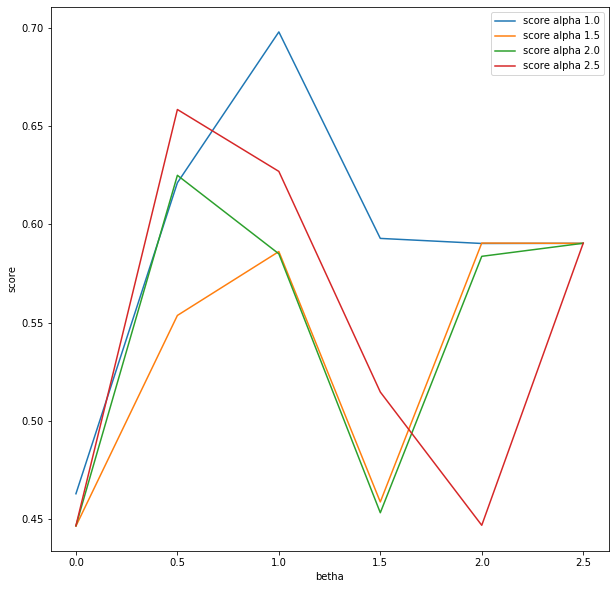

In [394]:
import matplotlib.pyplot as plt
import math
fig, ax = plt.subplots()
for i in range(len(score_)):
    ax.plot(betha, score_[i], label = 'score alpha {0}'.format(alpha[i]))
ax.legend()
fig.set_figheight(10)
fig.set_figwidth(10)
ax.set_xlabel('betha')
ax.set_ylabel('score')
plt.show()

зависимость значения функции потерь от реального времени работы метода и зависимость значения функции потерь от эпохи метода на обучающей выборке:

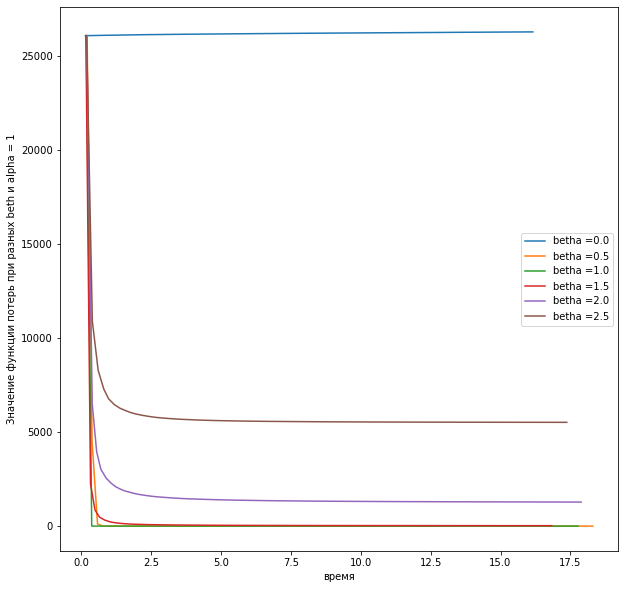

In [397]:
import matplotlib.pyplot as plt
import math
fig, ax = plt.subplots()
for i in range(len(betha)):
    ax.plot(getItime(((answ[alpha[0]][i]))[betha[i]][0]['time']), ((answ[alpha[0]][i]))[betha[i]][0]['func'], label = 'betha ={0}'.format(betha[i]))
ax.legend()
fig.set_figheight(10)
fig.set_figwidth(10)
ax.set_xlabel('время')
ax.set_ylabel('Значение функции потерь при разных beth и alpha = 1')
plt.show()


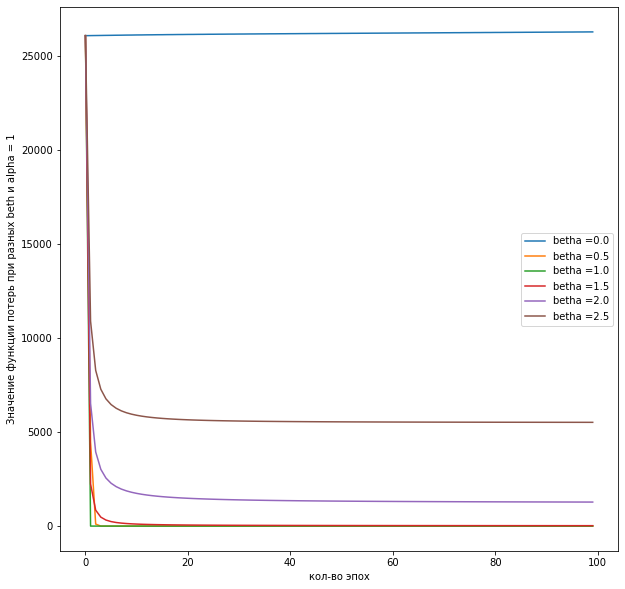

In [398]:
import matplotlib.pyplot as plt
import math
fig, ax = plt.subplots()
for i in range(len(betha)):
    ax.plot(np.arange(len(((answ[alpha[0]][i]))[betha[i]][0]['time'])), ((answ[alpha[0]][i]))[betha[i]][0]['func'], label = 'betha ={0}'.format(betha[i]))
ax.legend()
fig.set_figheight(10)
fig.set_figwidth(10)
ax.set_xlabel('кол-во эпох')
ax.set_ylabel('Значение функции потерь при разных beth и alpha = 1')
plt.show()


зависимость значения функции потерь от реального времени работы метода и зависимость значения функции потерь от эпохи метода на валидационной выборке:

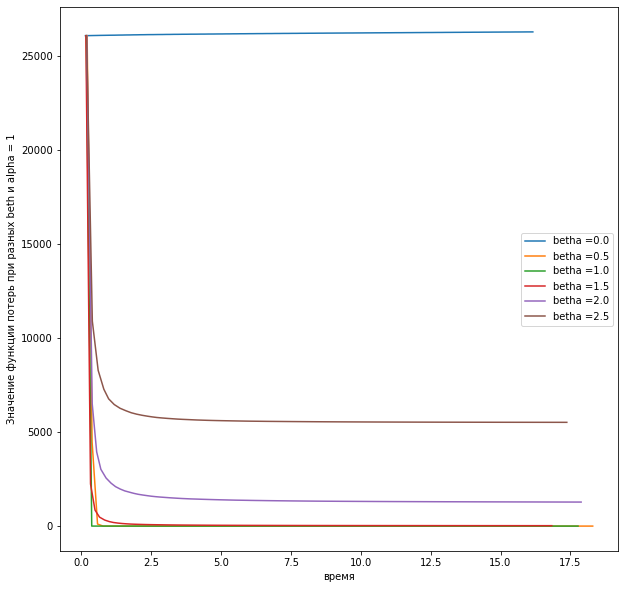

In [399]:
import matplotlib.pyplot as plt
import math
fig, ax = plt.subplots()
for i in range(len(betha)):
    ax.plot(getItime(((answ[alpha[0]][i]))[betha[i]][0]['time']), ((answ[alpha[0]][i]))[betha[i]][0]['func_val'], label = 'betha ={0}'.format(betha[i]))
ax.legend()
fig.set_figheight(10)
fig.set_figwidth(10)
ax.set_xlabel('время')
ax.set_ylabel('Значение функции потерь при разных beth и alpha = 1')
plt.show()


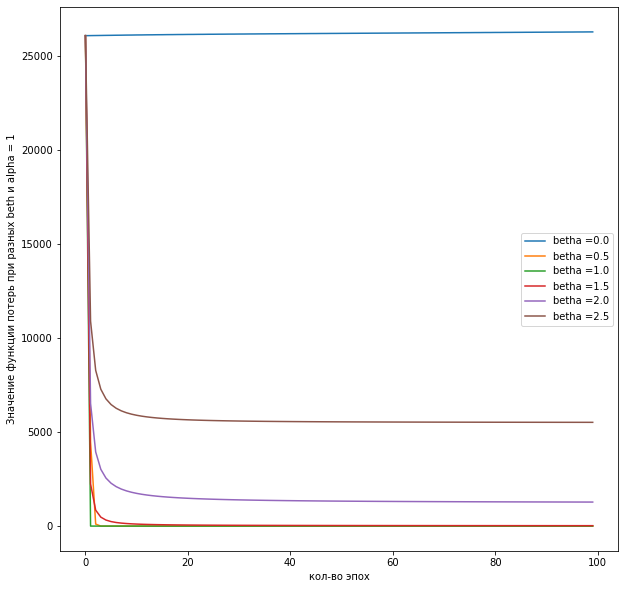

In [400]:
import matplotlib.pyplot as plt
import math
fig, ax = plt.subplots()
for i in range(len(betha)):
    ax.plot(np.arange(len(((answ[alpha[0]][i]))[betha[i]][0]['time'])), ((answ[alpha[0]][i]))[betha[i]][0]['func_val'], label = 'betha ={0}'.format(betha[i]))
ax.legend()
fig.set_figheight(10)
fig.set_figwidth(10)
ax.set_xlabel('кол-во эпох')
ax.set_ylabel('Значение функции потерь при разных beth и alpha = 1')
plt.show()


Аналогичные графики и для других значений alpha;
Максимальное качество показала модель с alpha = 1, betha = 1

# 5):

Так как расчеты дляться очень долго, то я не стал делать смежные поиски оптимальных alpha и betha. Поэтому будем сначала искать оптимальный alpha при дефолтном параметре betha = 0, а потом искать оптимальный betha при оптимальном alpha.

In [457]:
batches = [100, 200, 300, 400, 500]

In [461]:
result = {}
for i in range(len(alpha)):
    for j in range(len(betha)):
        for k in range(len(batches)):
            name = '{0}_{1}_{2}'.format(alpha[i], betha[j], batches[k])
            result[name]=[]
        
print(result)

{'1.0_0.0_100': [], '1.0_0.0_200': [], '1.0_0.0_300': [], '1.0_0.0_400': [], '1.0_0.0_500': [], '1.0_0.5_100': [], '1.0_0.5_200': [], '1.0_0.5_300': [], '1.0_0.5_400': [], '1.0_0.5_500': [], '1.0_1.0_100': [], '1.0_1.0_200': [], '1.0_1.0_300': [], '1.0_1.0_400': [], '1.0_1.0_500': [], '1.0_1.5_100': [], '1.0_1.5_200': [], '1.0_1.5_300': [], '1.0_1.5_400': [], '1.0_1.5_500': [], '1.0_2.0_100': [], '1.0_2.0_200': [], '1.0_2.0_300': [], '1.0_2.0_400': [], '1.0_2.0_500': [], '1.0_2.5_100': [], '1.0_2.5_200': [], '1.0_2.5_300': [], '1.0_2.5_400': [], '1.0_2.5_500': [], '1.5_0.0_100': [], '1.5_0.0_200': [], '1.5_0.0_300': [], '1.5_0.0_400': [], '1.5_0.0_500': [], '1.5_0.5_100': [], '1.5_0.5_200': [], '1.5_0.5_300': [], '1.5_0.5_400': [], '1.5_0.5_500': [], '1.5_1.0_100': [], '1.5_1.0_200': [], '1.5_1.0_300': [], '1.5_1.0_400': [], '1.5_1.0_500': [], '1.5_1.5_100': [], '1.5_1.5_200': [], '1.5_1.5_300': [], '1.5_1.5_400': [], '1.5_1.5_500': [], '1.5_2.0_100': [], '1.5_2.0_200': [], '1.5_2.0_30

In [462]:
for i in range(len(alpha)):
    for j in range(len(betha)):
        for k in range(len(batches)):
            name = '{0}_{1}_{2}'.format(alpha[i], betha[j], batches[k])
            loss_function = BinaryLogisticLoss(l2_coef=0.1)
            linear_model = LinearModel(
                loss_function=loss_function,
                batch_size=batches[k],
                step_alpha=alpha[i],
                step_beta=betha[j],
                tolerance=1e-5,
                max_iter=100,
            )
            history = linear_model.fit(X_train, y_train, trace=True, X_val=X_test, y_val=y_test)
            predictions = linear_model.predict(X_test)
            score = balanced_accuracy_score(y_test, predictions)
            result[name].append(history)
            result[name].append(score)
            print(name, " ...done")
                

1.0_0.0_100  ...done
1.0_0.0_200  ...done
1.0_0.0_300  ...done
1.0_0.0_400  ...done
1.0_0.0_500  ...done
1.0_0.5_100  ...done
1.0_0.5_200  ...done
1.0_0.5_300  ...done
1.0_0.5_400  ...done
1.0_0.5_500  ...done
1.0_1.0_100  ...done
1.0_1.0_200  ...done
1.0_1.0_300  ...done
1.0_1.0_400  ...done
1.0_1.0_500  ...done
1.0_1.5_100  ...done
1.0_1.5_200  ...done
1.0_1.5_300  ...done
1.0_1.5_400  ...done
1.0_1.5_500  ...done
1.0_2.0_100  ...done
1.0_2.0_200  ...done
1.0_2.0_300  ...done
1.0_2.0_400  ...done
1.0_2.0_500  ...done
1.0_2.5_100  ...done
1.0_2.5_200  ...done
1.0_2.5_300  ...done
1.0_2.5_400  ...done
1.0_2.5_500  ...done
1.5_0.0_100  ...done
1.5_0.0_200  ...done
1.5_0.0_300  ...done
1.5_0.0_400  ...done
1.5_0.0_500  ...done
1.5_0.5_100  ...done
1.5_0.5_200  ...done
1.5_0.5_300  ...done
1.5_0.5_400  ...done
1.5_0.5_500  ...done
1.5_1.0_100  ...done
1.5_1.0_200  ...done
1.5_1.0_300  ...done
1.5_1.0_400  ...done
1.5_1.0_500  ...done
1.5_1.5_100  ...done
1.5_1.5_200  ...done
1.5_1.5_300  

Проанализируем результаты:

In [463]:
scores__ = []
for i in range(len(alpha)):
    scores__.append([])
    for j in range(len(betha)):
        scores__[i].append([])
        for k in range(len(batches)):
            name = '{0}_{1}_{2}'.format(alpha[i], betha[j], batches[k])
            scores__[i][j].append(result[name][1])

In [470]:
getItime(result[name][0]['time'])

array([ 0.22145343,  0.55465078,  0.76210594,  0.97602463,  1.23114991,
        1.47047257,  1.78468275,  2.0868783 ,  2.39704871,  2.72113585,
        3.02832294,  3.35050893,  3.69259667,  4.01254869,  4.31674147,
        4.62931752,  4.93017483,  5.23740244,  5.5535996 ,  5.84676719,
        6.17988157,  6.50942397,  6.81261373,  7.11580539,  7.43695569,
        7.74612856,  8.07546306,  8.39665508,  8.70583916,  9.02004862,
        9.353163  ,  9.66234732,  9.9924593 , 10.3219049 , 10.61826921,
       10.94944477, 11.2775743 , 11.57682109, 11.91407752, 12.23127246,
       12.5454812 , 12.87659955, 13.20372605, 13.50596762, 13.84510565,
       14.16624618, 14.4744668 , 14.81356573, 15.12645102, 15.3259182 ,
       15.53934789, 15.82922053, 16.02799702, 16.23433518, 16.51839542,
       16.76573706, 17.09386492, 17.38413811, 17.69986033, 18.01398468,
       18.32619405, 18.64928889, 18.96639848, 19.23173666, 19.54590654,
       19.8909831 , 20.21512318, 20.54320765, 20.83845901, 21.16

In [464]:
print(scores__)

[[[0.5687120912133771, 0.5779395027298512, 0.5591588778160048, 0.5615580227016864, 0.6232671915504606], [0.6308714529748274, 0.6285222930873771, 0.563173970420918, 0.5697625839415219, 0.6327939536487206], [0.6242507844341324, 0.5450820293124182, 0.4653996078051172, 0.45239589357011883, 0.45014010893865064], [0.5130925708278504, 0.4511331104794907, 0.45018656870449336, 0.44914637196971313, 0.4483558205222884], [0.4506602229790986, 0.44936632042936886, 0.4489728832759001, 0.4483558205222884, 0.44784549852611527], [0.45151330992720484, 0.44903242883939865, 0.4487398490185888, 0.4480661824138685, 0.44742883148972523]], [[0.7741366006620993, 0.6017561680571546, 0.559595097594829, 0.5953954407971798, 0.6343835778645421], [0.6259400989426155, 0.6160113783699148, 0.74501627143105, 0.5666011135799205, 0.6245774736512268], [0.6275575175180419, 0.6757157268226724, 0.6637908687279847, 0.48755772604204806, 0.45269861747619444], [0.6374064043567127, 0.4565232583162595, 0.4520555350353702, 0.45010511

Построим график зависимости значения метрики качества после обучения метода от количества этох для различный alpha и betha

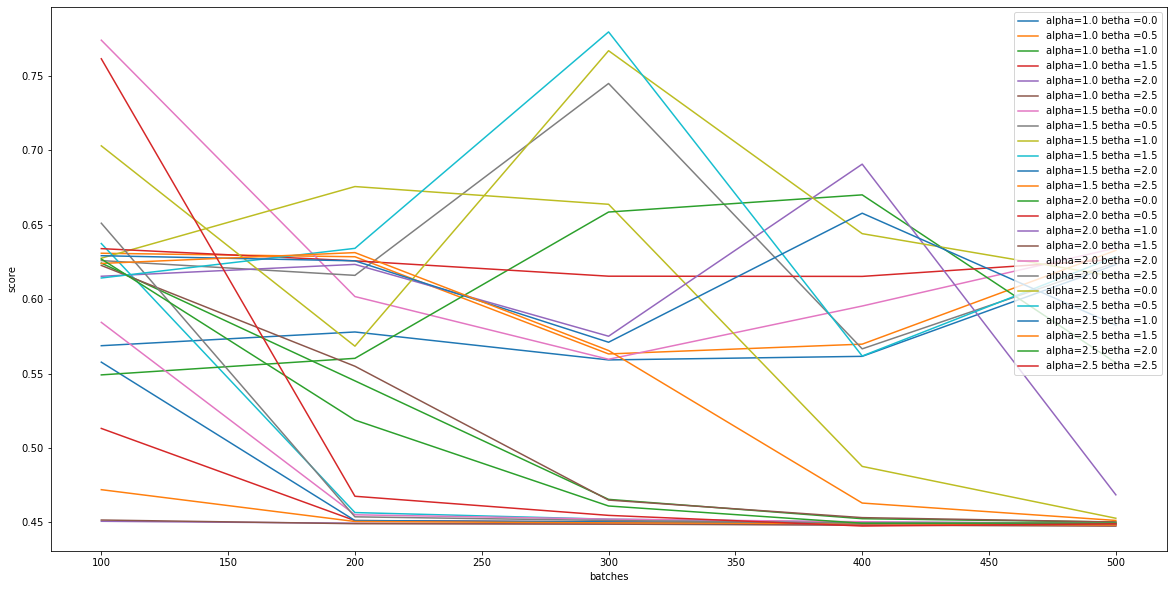

In [467]:
import matplotlib.pyplot as plt
import math
fig, ax = plt.subplots()
for i in range(len(alpha)):
    for j in range(len(betha)):
        ax.plot(batches, scores__[i][j], label = 'alpha={0} betha ={1}'.format(alpha[i], betha[j]))
ax.legend()
fig.set_figheight(10)
fig.set_figwidth(20)
ax.set_xlabel('batches')
ax.set_ylabel('score')
plt.show()


Видно, что лучшее качество достигается при alpha = 1.5, betha = 1.5, batches = 300 

Аналогично предыдущему пункту проанализируем зависимость значения функции потерь от реального времени работы метода
и зависимость значения функции потерь от эпохи метода на тренировочных данных:

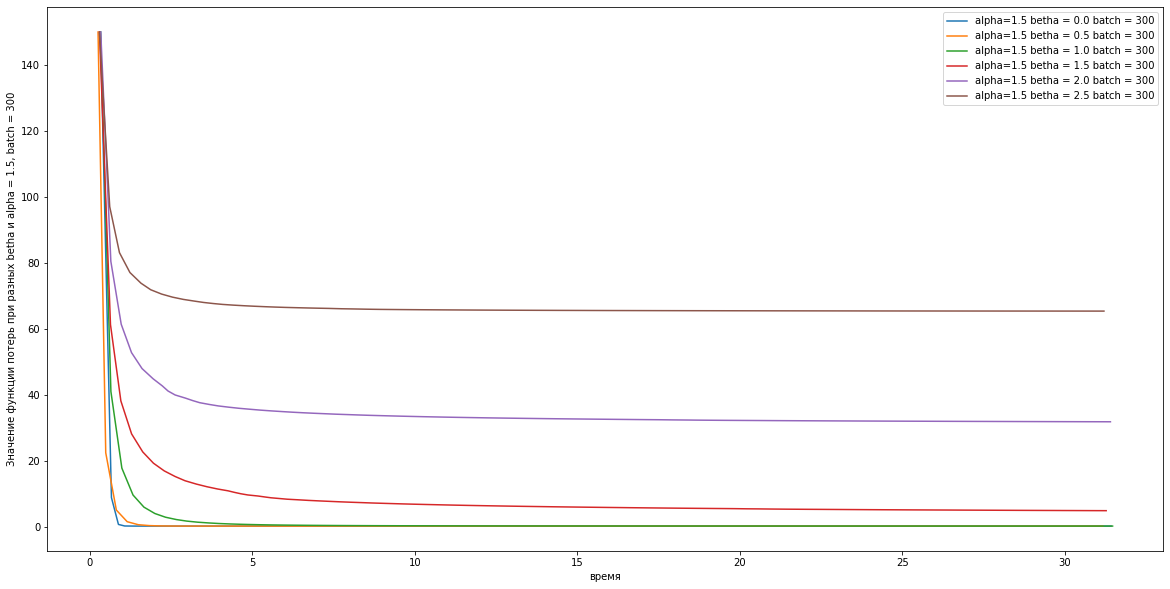

In [476]:
import matplotlib.pyplot as plt
import math
fig, ax = plt.subplots()
for j in range(len(betha)):
    name = '{0}_{1}_{2}'.format('1.5', betha[j], 300)
    ax.plot(getItime(result[name][0]['time']), result[name][0]['func'], label = 'alpha={0} betha = {1} batch = {2}'.format(1.5, betha[j], 300))
        
ax.legend()
fig.set_figheight(10)
fig.set_figwidth(20)
ax.set_xlabel('время')
ax.set_ylabel('Значение функции потерь при разных betha и alpha = 1.5, batch = 300')
plt.show()


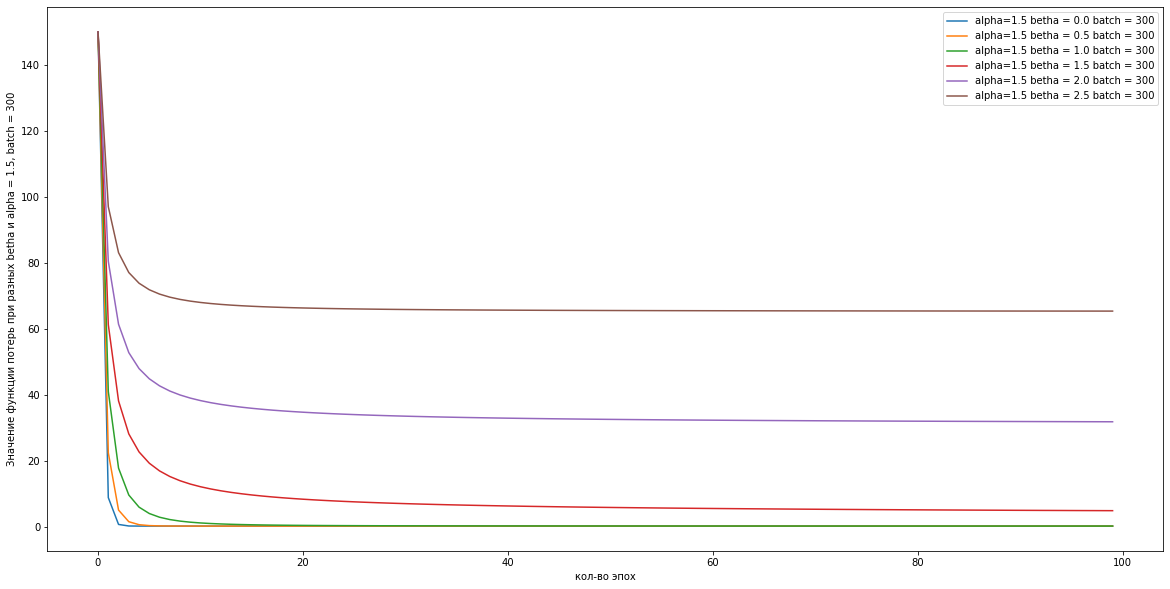

In [478]:
import matplotlib.pyplot as plt
import math
fig, ax = plt.subplots()
for j in range(len(betha)):
    name = '{0}_{1}_{2}'.format('1.5', betha[j], 300)
    ax.plot(np.arange(len(result[name][0]['func'])), result[name][0]['func'], label = 'alpha={0} betha = {1} batch = {2}'.format(1.5, betha[j], 300))
        
ax.legend()
fig.set_figheight(10)
fig.set_figwidth(20)
ax.set_xlabel('кол-во эпох')
ax.set_ylabel('Значение функции потерь при разных betha и alpha = 1.5, batch = 300')
plt.show()


Графики ведут себя аналогично и для других alpha и betha...они здесь не приведены, т.к. на одном графики разместить их было бы слишком громоздко.

Для валидационной выборки:

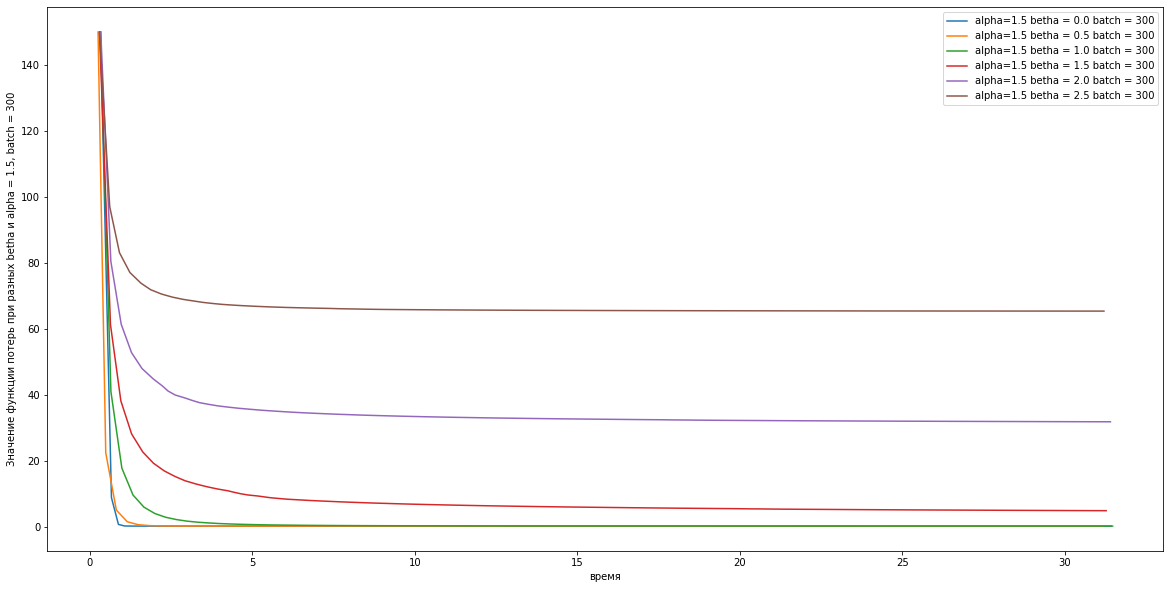

In [479]:
import matplotlib.pyplot as plt
import math
fig, ax = plt.subplots()
for j in range(len(betha)):
    name = '{0}_{1}_{2}'.format('1.5', betha[j], 300)
    ax.plot(getItime(result[name][0]['time']), result[name][0]['func_val'], label = 'alpha={0} betha = {1} batch = {2}'.format(1.5, betha[j], 300))
        
ax.legend()
fig.set_figheight(10)
fig.set_figwidth(20)
ax.set_xlabel('время')
ax.set_ylabel('Значение функции потерь при разных betha и alpha = 1.5, batch = 300')
plt.show()


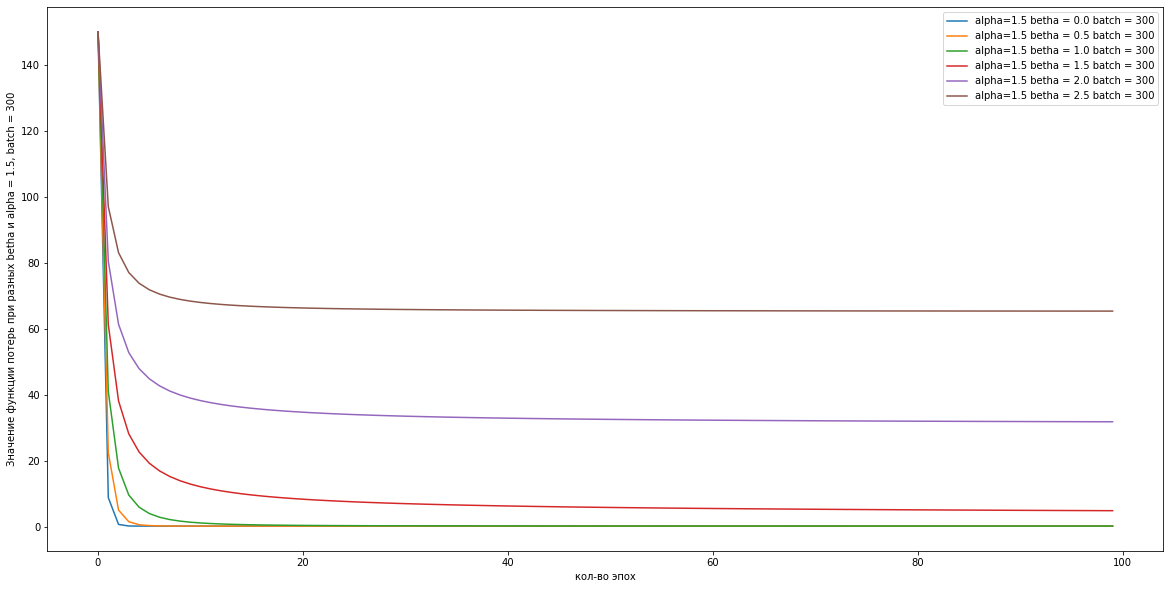

In [480]:
import matplotlib.pyplot as plt
import math
fig, ax = plt.subplots()
for j in range(len(betha)):
    name = '{0}_{1}_{2}'.format('1.5', betha[j], 300)
    ax.plot(np.arange(len(result[name][0]['func_val'])), result[name][0]['func_val'], label = 'alpha={0} betha = {1} batch = {2}'.format(1.5, betha[j], 300))
        
ax.legend()
fig.set_figheight(10)
fig.set_figwidth(20)
ax.set_xlabel('кол-во эпох')
ax.set_ylabel('Значение функции потерь при разных betha и alpha = 1.5, batch = 300')
plt.show()


# 6):

Видно, что обучение с батчами происходит лучше и дает лучший результат, это связано с тем, что веса при градиентном спуске изменяются более меньшими шагами, что дает возможность подобраться к минимуму функции потерь наилучшим способом, при обучении без батчей этот процесс будет более грубым. alpha = 1, betha = 1 - мы получили в обучении без батчей, а alpha = 1.5, betha = 1.5-при обучении с батчами, видно, что при обучении с батчами модель настраивается более тонко, и более точно приближается к минимуму функции потерь из-за корректировки шага с помощью alpha и betha.

# 7):

In [487]:
lam = np.arange(0.5,2,0.1)
print(lam)
alpha = 1.5
betha = 1.5
batch = 300

[0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9]


In [488]:
new_score = []
for l in lam:
    loss_function = BinaryLogisticLoss(l2_coef = l)
    linear_model = LinearModel(
                loss_function=loss_function,
                batch_size=batch,
                step_alpha=alpha,
                step_beta=betha,
                tolerance=1e-5,
                max_iter=100,
            )
    linear_model.fit(X_train, y_train)
    predictions = linear_model.predict(X_test)
    score = balanced_accuracy_score(y_test, predictions)
    new_score.append(score)
    print(l,"... done")

0.5 ... done
0.6 ... done
0.7 ... done
0.7999999999999999 ... done
0.8999999999999999 ... done
0.9999999999999999 ... done
1.0999999999999999 ... done
1.1999999999999997 ... done
1.2999999999999998 ... done
1.4 ... done
1.4999999999999998 ... done
1.5999999999999996 ... done
1.6999999999999997 ... done
1.7999999999999998 ... done
1.8999999999999997 ... done


In [509]:
index = new_score.index(max(new_score))
print(lam[index])

0.8999999999999999


# 8):

In [495]:
df_test = pd.read_csv('test.csv')
df_test.head(10)

,comment_text,is_toxic,toxic_level,insult,obscene,obscene_and_insult,no_obscene_no_insult
0,Thank you for understanding. I think very high...,0,0,0,0,0,0
1,:Dear god this site is horrible.,0,0,0,0,0,0
2,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0
3,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0
4,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0
5,this other one from 1897,0,0,0,0,0,0
6,== Reason for banning throwing == \n\n This ar...,0,0,0,0,0,0
7,|blocked]] from editing Wikipedia. |,0,0,0,0,0,0
8,"== Arabs are committing genocide in Iraq, but ...",1,1,0,0,0,1
9,Please stop. If you continue to vandalize Wiki...,0,0,0,0,0,0


In [496]:
data_test = df_test['comment_text'].str.lower().apply(preprocessing)
print(len(data_test))

63978


In [498]:
target_test = copy.deepcopy(df_test['is_toxic'])
target_test[target_test == 0]=-1
target_test = target_test.to_numpy()
print(len(target_test))

63978


In [499]:
indexes_test = data_test.notna()
data_test = data_test[indexes_test]
target_test = target_test[indexes_test]

In [503]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df = 5)
vectorizer.fit(data)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=5, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [504]:
X_train_f = vectorizer.transform(data)
X_test_f = vectorizer.transform(data_test)

In [505]:
X_train_f = csr_matrix(hstack([csr_matrix(np.ones((X_train_f.shape[0], 1))), X_train_f]))
X_test_f = csr_matrix(hstack([csr_matrix(np.ones((X_test_f.shape[0], 1))), X_test_f]))

In [506]:
print(X_train_f.shape)
print(X_test_f.shape)
print(target.shape)
print(target_test.shape)

(159550, 32342)
(63578, 32342)
(159550,)
(63578,)


In [510]:
alpha = 1.5
betha = 1.5
batch = 300
lambd = lam[index]

In [512]:
loss_function = BinaryLogisticLoss(l2_coef=lambd)
linear_model = LinearModel(
                loss_function=loss_function,
                batch_size=batch,
                step_alpha=alpha,
                step_beta=betha,
                tolerance=1e-5,
                max_iter=100,
            )
linear_model.fit(X_train_f, target)
predictions = linear_model.predict(X_test_f)
score = balanced_accuracy_score(target_test, predictions)
            

Проанализируем данные на которых были ошибки:

In [523]:
print(score)

0.8384546931946758


In [526]:
errors_index = []
for i in range(len(predictions)):
    if predictions[i]!=target_test[i]:
        errors_index.append(i)


In [527]:
errors_data = copy.deepcopy(df_test['comment_text'])
errors_data = errors_data[indexes_test]

In [531]:
for i,j in enumerate(errors_index):
    print(errors_data[errors_index[j]], "RIGHT ANSW = ", target_test[i])
    if i == 5:
        break;

" 
 ::Lol, and there we have it, right on time. As far as I remember, the only person who kept raving about ""undue weight"" was yourself, so I fail to see how that can be the reason for anything. The third row was reverted simply because you and three others didn't like it. But I see, the details of a civil war are determined by numbers. In fact, this entire page seems to be testament to the fact that terms can be redefined to serve an agenda. Israel cannot be part of the infobox, because external factions need to make a ""certain number"" of attacks. A war faction can't be considered separate because it has not contributed with a ""certain percentage"" of fighting. Are you fucking kidding me?   " RIGHT ANSW =  -1
" 

 == A little late, but... == 

 Andy, I just noticed this  I feel you should know that Sledge did not delete your comment. I did. Your post was not appropriate anywhere on Wikipedia, even addressed to a ""troll"" or ""idiot"".   " RIGHT ANSW =  -1
projective special orth

Общим в данных предложениях является присутствие нецензурных выражений, возможно в обучающем датасете не было именно таких фраз, именно поэтому модель не смогла верно классифицировать предложение. Также из-за того, что модель очень долго обучается на большом датасете из-за того, что вычислительные мощности достаточно ограничены, то невозможно было найти обтимальные параметры.